In [2]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
import psutil
import warnings
import os

warnings.filterwarnings("ignore")
process = psutil.Process(os.getpid())

In [3]:
class KMeans:
    """KMeans clustering algorithm implementation."""
    
    def __init__(self, k=3, threshold=0.1, verbose=0, random_state=42):
        """
        Initialize KMeans instance.

        Parameters:
        - k: int, default=3
            Number of clusters.
        - threshold: float, default=0.1
            Threshold value for the stopping criterion.
        - verbose: int, default=0
            Controls verbosity during fitting.
        - random_state: int, default=42
            Seed used for random initialization.
        """
        self.k = k
        self.threshold = threshold
        self.verbose = verbose
        np.random.seed(random_state)
    
    def initialize_centroids(self, init):
        """
        Initialize centroids based on the selected method.

        Parameters:
        - init: str
            Initialization method. Supported values: 'kmean', 'kmean++'.
        """
        if init == 'kmean':
            # Centroid ids randomly chosen
            self.centroid_ids = np.random.choice(self.n, self.k, replace=False)
        elif init == 'kmean++':
            first_centroid = np.random.randint(self.n)
            centroid_ids = [first_centroid]
            for _ in range(self.k - 1):
                distances = self.distances[:, centroid_ids].min(axis=1)

                # To make the sum 1 for probabilities
                distances = (distances / distances.sum()).tolist()
                centroid_id = np.random.choice(self.n, p=distances)
                centroid_ids.append(centroid_id)
            self.centroid_ids = np.array(centroid_ids)
        else:
            print("Give a valid 'init' parameter")
            return True
    
    def update_centroids(self):
        """Update centroids based on the current clusters."""
        centroid_ids = []
        for centroid in self.old_centroid_ids:
            cluster_mem_ids = np.where(self.clusters_ids == centroid)[0]
            new_c = cluster_mem_ids[self.distances[:, cluster_mem_ids][cluster_mem_ids, :].sum(axis=1).argmin()]
            centroid_ids.append(new_c)
        self.centroid_ids = np.array(centroid_ids)
    
    @property
    def stopping_criterion(self):
        """Compute average distance from old centroids to new centroids"""
        diff = 0
        for i in range(self.k):
            diff += self.distances[self.centroid_ids[i], self.old_centroid_ids[i]]
        if self.verbose:
            print('Distance b/w latest centroid and previous centroid :', diff / self.k)
        return diff / self.k <= self.threshold
    
    def fit(self, distances, max_iterations = 10, init = 'kmean'):
        """
        Fit the KMeans model to the data.

        Parameters:
        - distances: numpy.ndarray
            Distance matrix representing distances between points.
        - max_iterations: int, default=10
            Maximum number of iterations.
        - init: str, default='kmean'
            Initialization method. Supported values: 'kmean', 'kmean++'.
        """
        self.n = distances.shape[0]
        self.distances = distances
        
        # initializing the centroids
        self.initialize_centroids(init)
        
        # centroid id for each document
        self.clusters_ids = self.centroid_ids[self.distances[:, self.centroid_ids].argmin(axis=1)]        
        
        for iter in range(max_iterations):
            # Copying current centroids to old_centroids before updating centroids
            self.old_centroid_ids = self.centroid_ids.copy()
            
            # Updating centroids
            self.update_centroids()
            
            # centroid id for each document
            self.clusters_ids = self.centroid_ids[self.distances[:, self.centroid_ids].argmin(axis=1)]
            
            # stopping criterion
            if self.stopping_criterion:
                print(f"Training stopped at the iteration {iter}") if self.verbose else None    
                break
            
            print(f"AT iteration {iter} WCSS: {self.WCSS}") if self.verbose else None
        
    @property
    def WCSS(self):
        """Calculate Within-Cluster Sum of Squares."""
        wcss = 0
        for c in self.centroid_ids:
            cluster_mem_ids = np.where(self.clusters_ids == c)[0]
            wcss += self.distances[cluster_mem_ids, c].sum()
        return wcss


# For KOS dataset


In [26]:
# Reading the dataset
df = pd.read_csv('./bag+of+words/docword.kos.txt', skiprows=3, sep=' ', header=None)
kos_dataset = df.pivot(index=0, columns=1, values=2).fillna(0)
kos_distances = pairwise_distances(kos_dataset.to_numpy(), metric='jaccard', n_jobs=-1)

In [27]:
start_time = time.time()
start_memory = process.memory_info().rss

WCSS_scores = []
KS = range(3, 21, 2)
for k in KS:
    print(f"Fitting Kmean for {k = }")
    kmean = KMeans(k=k, verbose=0, threshold=0.0001, random_state=0)
    kmean.fit(kos_distances, max_iterations=10, init='kmean')
    WCSS_scores.append(kmean.WCSS)
    
end_time = time.time()
end_memory = process.memory_info().rss

print(f"Time taken in training: {round(end_time-start_time, 2)} sec")
print(f"Memory taken in training: {round((end_memory-start_memory)/1024, 2)} MB")

Fitting Kmean for k = 3
Fitting Kmean for k = 5
Fitting Kmean for k = 7
Fitting Kmean for k = 9
Fitting Kmean for k = 11
Fitting Kmean for k = 13
Fitting Kmean for k = 15
Fitting Kmean for k = 17
Fitting Kmean for k = 19
Time taken in training: 2.75 sec
Memory taken in training: 28.0 MB


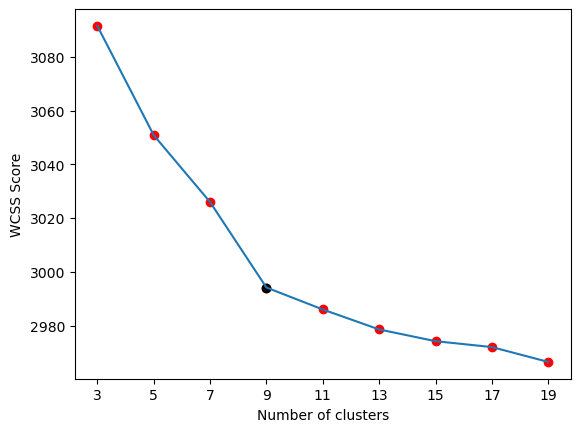

In [5]:
plt.plot(KS, WCSS_scores)
plt.scatter(KS, WCSS_scores, color='red')
plt.scatter(KS[3], WCSS_scores[3], color='black')
plt.xticks(KS)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS Score')
plt.show()

# For NIPS dataset


In [8]:
# Reading the dataset
df = pd.read_csv('./bag+of+words/docword.nips.txt', skiprows=3, sep=' ', header=None)
nips_dataset = df.pivot(index=0, columns=1, values=2).fillna(0)
nips_distances = pairwise_distances(nips_dataset.to_numpy(), metric='jaccard', n_jobs=-1)

In [18]:
start_time = time.time()
start_memory = process.memory_info().rss

WCSS_scores = []
KS = range(3, 20, 2)
for k in KS:
    print(f"Fitting Kmean for {k = }")
    kmean = KMeans(k=k, verbose=0, threshold=0.0001, random_state=102)
    kmean.fit(nips_distances, max_iterations=10, init='kmean++')
    WCSS_scores.append(kmean.WCSS)
    
end_time = time.time()
end_memory = process.memory_info().rss

print(f"Time taken in training: {round(end_time-start_time, 2)} sec")
print(f"Memory taken in training: {round((end_memory-start_memory)/1024, 2)} MB")

Fitting Kmean for k = 3
Fitting Kmean for k = 5
Fitting Kmean for k = 7
Fitting Kmean for k = 9
Fitting Kmean for k = 11
Fitting Kmean for k = 13
Fitting Kmean for k = 15
Fitting Kmean for k = 17
Fitting Kmean for k = 19
Time taken in training: 0.43 sec
Memory taken in training: 4.0 MB


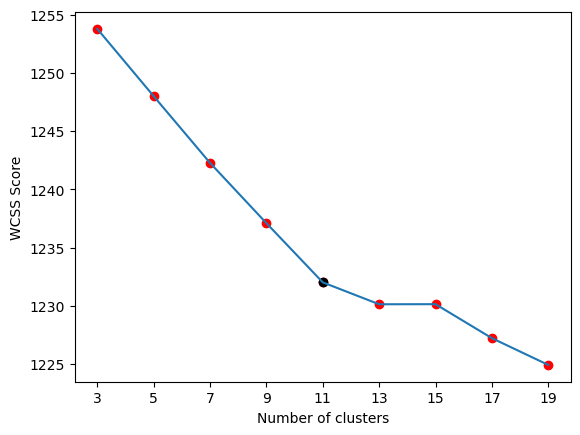

In [19]:
plt.plot(KS, WCSS_scores)
plt.scatter(KS, WCSS_scores, color='red')
plt.scatter(KS[4], WCSS_scores[4], color='black')
plt.xticks(KS)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS Score')
plt.show()

# For ENRON dataset


In [4]:
# Reading the dataset
df = pd.read_csv('./bag+of+words/docword.enron.txt', skiprows=3, sep=' ', header=None)
enron_dataset = df.pivot(index=0, columns=1, values=2).fillna(0).sample(frac=0.1, random_state=0)
enron_distances = pairwise_distances(enron_dataset.to_numpy(), metric='jaccard', n_jobs=-1)

In [13]:
start_time = time.time()
start_memory = process.memory_info().rss

WCSS_scores = []
KS = range(7, 20, 2)
for k in KS:
    print(f"Fitting Kmean for {k = }")
    kmean = KMeans(k=k, verbose=0, threshold=0.001, random_state=8)
    kmean.fit(enron_distances, max_iterations=10, init='kmean++')
    WCSS_scores.append(kmean.WCSS)
    
end_time = time.time()
end_memory = process.memory_info().rss

print(f"Time taken in training: {round(end_time-start_time, 2)} sec")
print(f"Memory taken in training: {round((end_memory-start_memory)/1024, 2)} MB")

Fitting Kmean for k = 7
Fitting Kmean for k = 9
Fitting Kmean for k = 11
Fitting Kmean for k = 13
Fitting Kmean for k = 15
Fitting Kmean for k = 17
Fitting Kmean for k = 19
Time taken in training: 2.05 sec
Memory taken in training: 16.0 MB


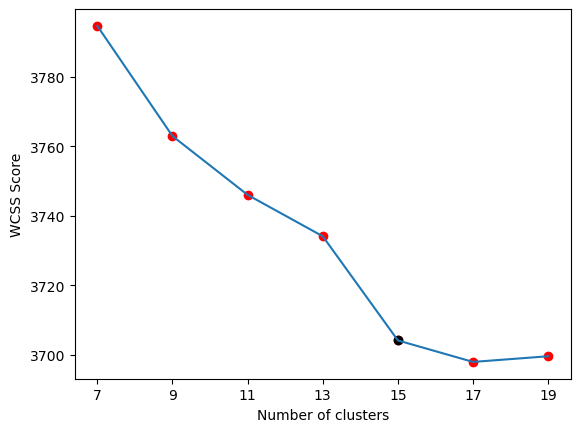

In [15]:
plt.plot(KS, WCSS_scores)
plt.scatter(KS, WCSS_scores, color='red')
plt.scatter(KS[4], WCSS_scores[4], color='black')
plt.xticks(KS)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS Score')
plt.show()